In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import rioxarray
import scipy.io as sio
import datetime
import pandas as pd
from scipy.signal import argrelextrema, argrelmax, argrelmin
from shapely.geometry import Polygon
import geojson
import mat73
import ir_utils
import aster_utils
import glob
import geopandas as gpd

In [ ]:
def get_hist_peaks(data,n_peaks=2):
    # remove nans from data
    data = data[~np.isnan(data)]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find maximum n_peaks
    peak_y_values = np.sort(n_histogram[argrelmax(n_histogram, order=2)])[-n_peaks:][::-1]
    # find corresponding x values to the n_peaks
    peak_x_values = x[np.where(np.isin(n_histogram,peak_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(peak_x_values, peak_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return peak_x_values, peak_y_values, x_hist, y_hist

In [ ]:
def get_hist_trough(data):
    # first, find peaks
    x_peaks, y_peaks, _, _ = get_hist_peaks(data)
    
    # only look at data between the two peaks
    data = data[(data > x_peaks[0]) & (data < x_peaks[1])]
    
    # data histogram
    n_histogram, _ = np.histogram(data, bins=100, density=True)
    
    # make our own data bins of length n
    x = np.linspace(np.min(data), np.max(data), num=len(n_histogram))
    
    # find minimum n_troughs
    if len(np.sort(n_histogram[argrelmin(n_histogram, order=1)]))>1:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])[0]
    else:
        trough_y_values = np.sort(n_histogram[argrelmin(n_histogram, order=1)])
    # find corresponding x values to the n_troughs
    trough_x_values = x[np.where(np.isin(n_histogram,trough_y_values))]
    
    # demo plot
    #plt.bar(x, n_histogram)
    #plt.plot(trough_x_values, trough_y_values,'or')
    
    x_hist = x
    y_hist = n_histogram
    
    return trough_x_values, trough_y_values, x_hist, y_hist

Convert .mat to .geotiff

In [4]:
#files = [r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb08_mosaicked.mat',
#         r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_EO_PLANE_2020Feb08_mosaicked.mat',
#         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb10_mosaicked.mat',
#         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked.mat',
#         # r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\mat\SNOWEX2020_IR_PLANE_2020Feb12_mosaicked.mat'
#        ]
#
#ds_eo = ir_utils.eo_mat2dataset(files[1])
#
#ds_ir = ir_utils.ir_mat2dataset(files[0])
#
#for i in range(ds_ir.time.size):
#    datetime_string = str(ds_ir.isel(time=i).time.values).replace(':','').split('.')[0]
#    filepath = r"C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\tif\\"
#    new_filename = f'SNOWEX2020_IR_PLANE_2020Feb11_mosaicked_{datetime_string}.tif'
#    ds_ir.isel(time=i).rio.to_raster(f"{filepath}{new_filename}")

Find geotiff files we just created

In [22]:
filepaths = glob.glob(r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\IR_PLANE_PROCESSED\tif\*_2020Feb11_*.tif')
print(filepaths)

['C:\\Users\\steve\\OneDrive\\Documents\\School Stuff\\UW\\Mountain Hydrology Research Group\\IR_PLANE_PROCESSED\\tif\\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked_2020-02-11T170132.tif', 'C:\\Users\\steve\\OneDrive\\Documents\\School Stuff\\UW\\Mountain Hydrology Research Group\\IR_PLANE_PROCESSED\\tif\\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked_2020-02-11T171501.tif', 'C:\\Users\\steve\\OneDrive\\Documents\\School Stuff\\UW\\Mountain Hydrology Research Group\\IR_PLANE_PROCESSED\\tif\\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked_2020-02-11T172551.tif', 'C:\\Users\\steve\\OneDrive\\Documents\\School Stuff\\UW\\Mountain Hydrology Research Group\\IR_PLANE_PROCESSED\\tif\\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked_2020-02-11T174011.tif', 'C:\\Users\\steve\\OneDrive\\Documents\\School Stuff\\UW\\Mountain Hydrology Research Group\\IR_PLANE_PROCESSED\\tif\\SNOWEX2020_IR_PLANE_2020Feb11_mosaicked_2020-02-11T175047.tif', 'C:\\Users\\steve\\OneDrive\\Documents\\School Stuff\\UW\\Mountain Hydrology Research Gro

Get shapefile

In [23]:
shapefile_filepath = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\MountainGOES\Mountain GOES Paper\Paper 2 - satellite vs ground\Paper 2a - snowex data\data\pixels_GOES-16_ABI.geojson'

Iterate through all images, use shapefile to compute zonal stats

C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform

zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\steve\git\snowex2020\ir_utils.py:197: RuntimeWarning: Mean of empty slice.
  masked_ir_tb_mean = values.mean()
C:\Users\steve\miniconda3\envs\feb8env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


zero-size array to reduction operation maximum which has no identity


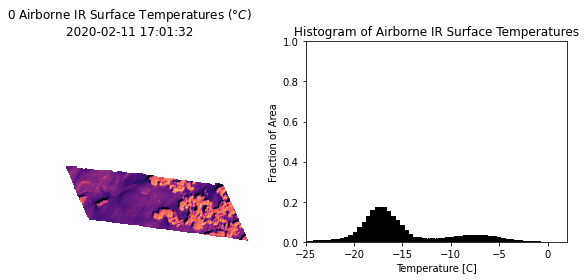

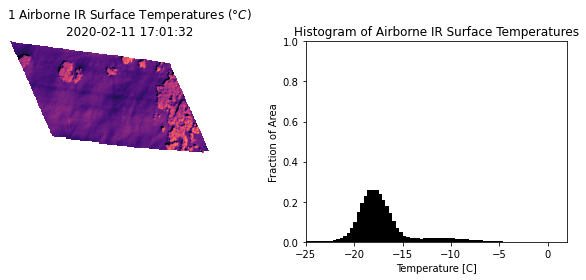

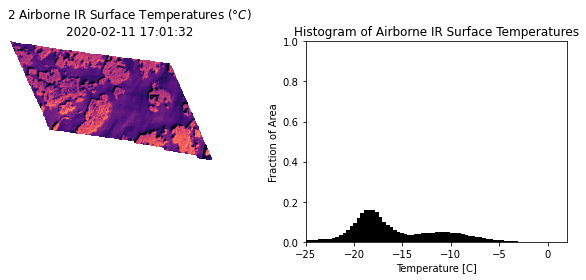

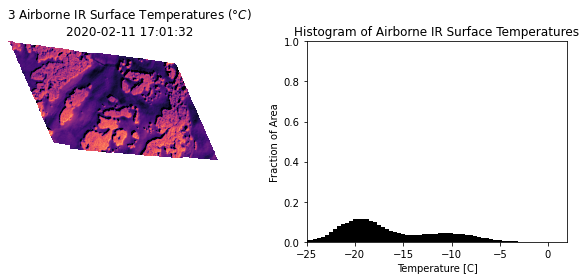

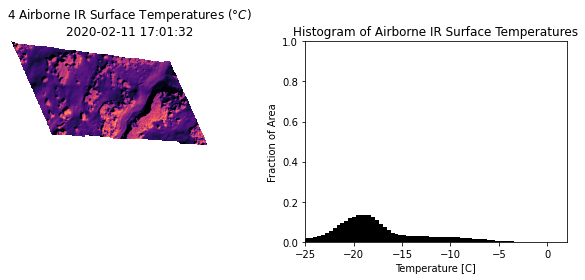

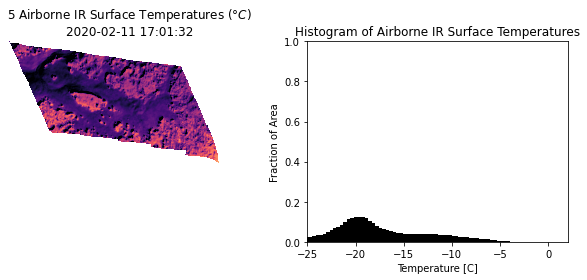

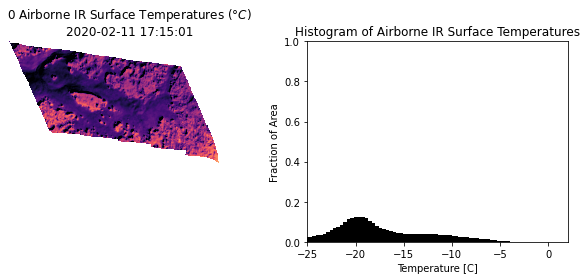

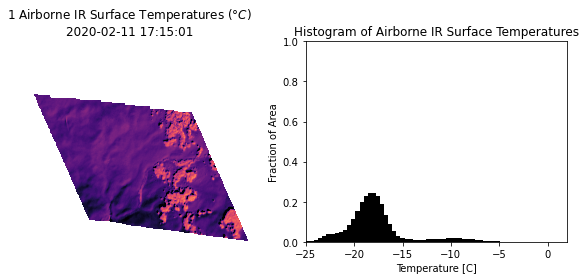

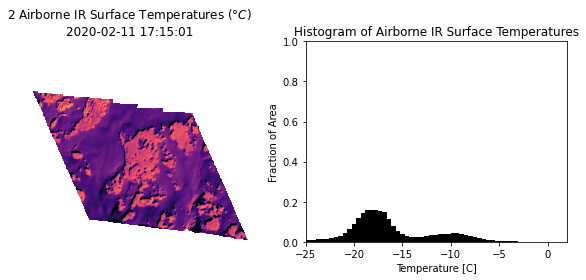

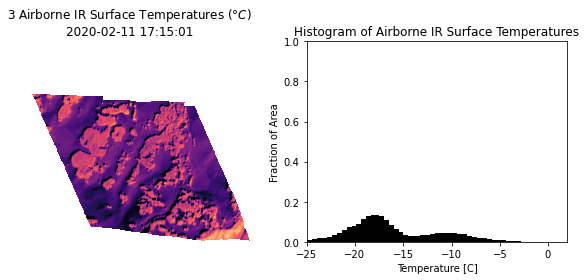

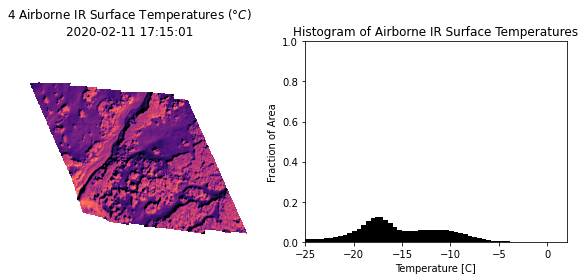

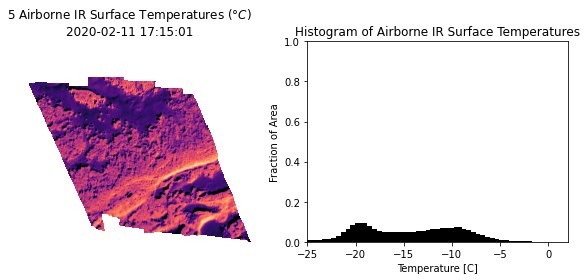

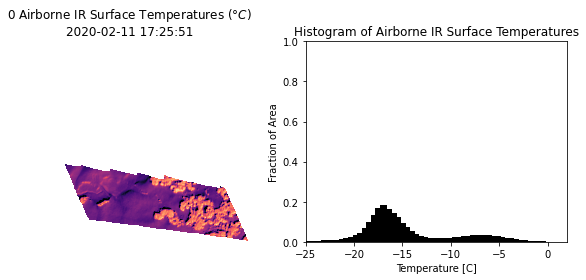

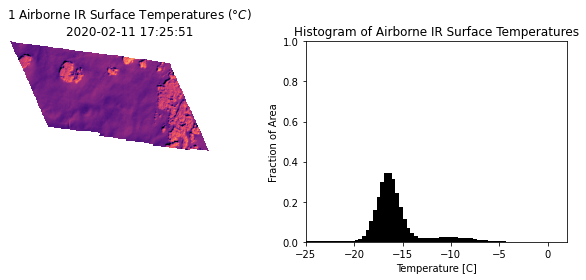

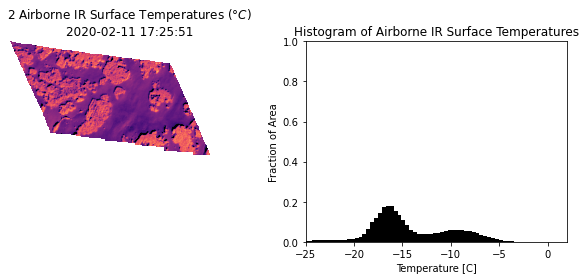

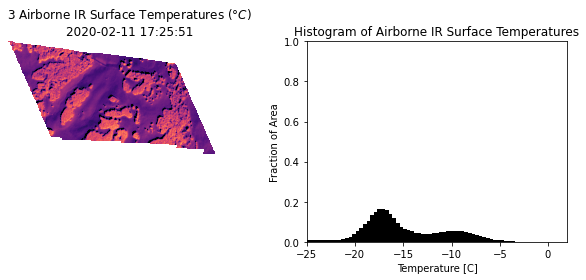

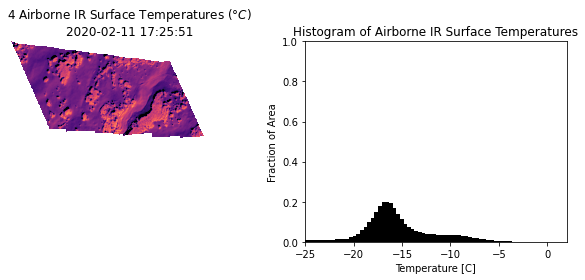

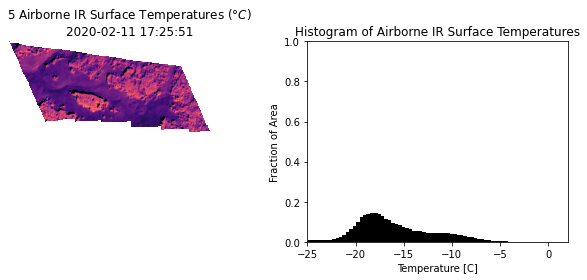

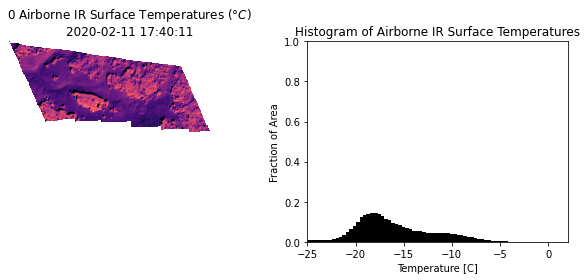

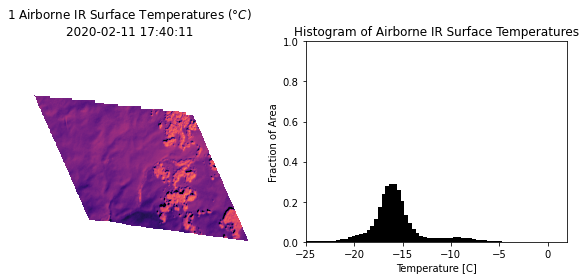

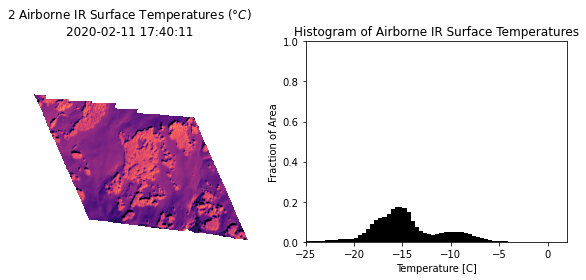

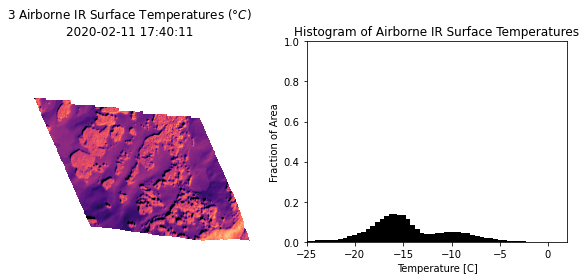

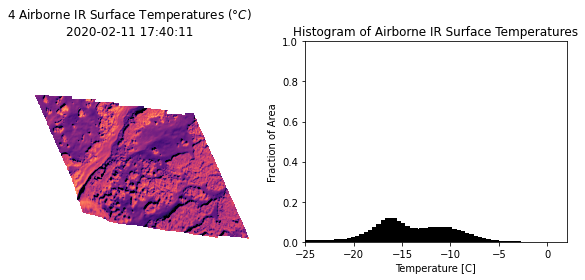

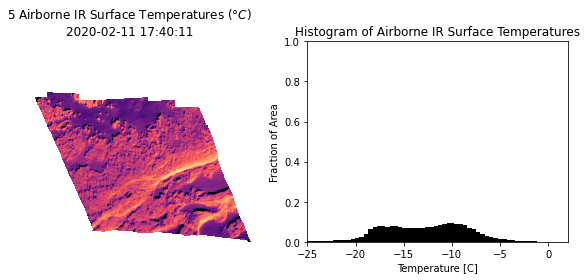

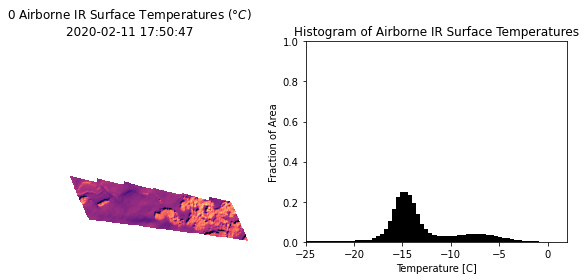

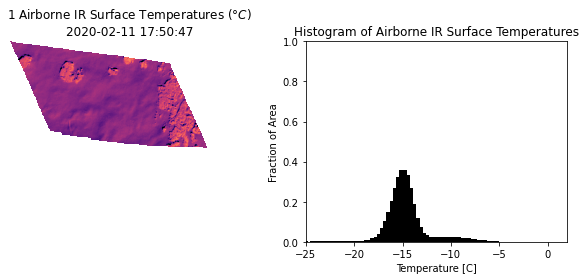

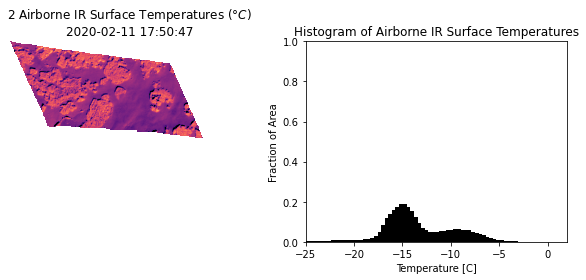

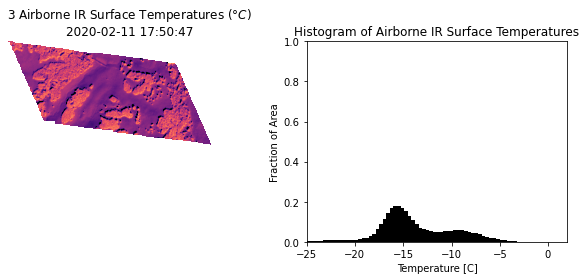

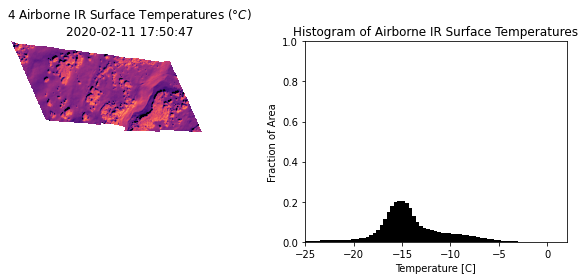

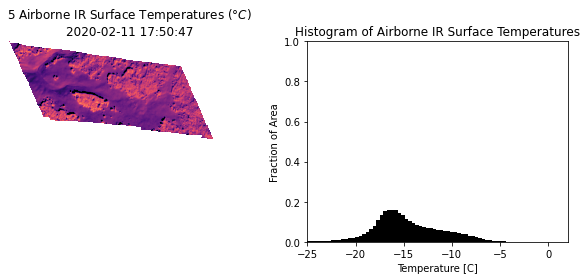

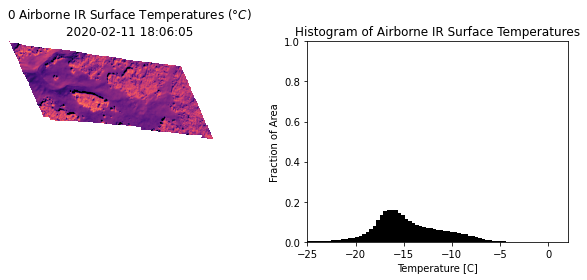

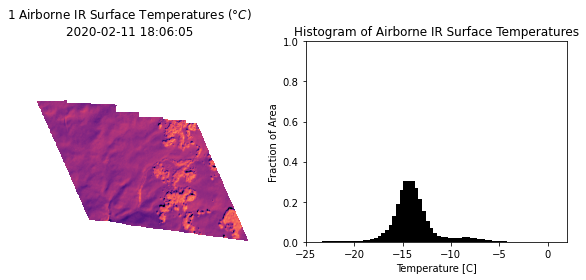

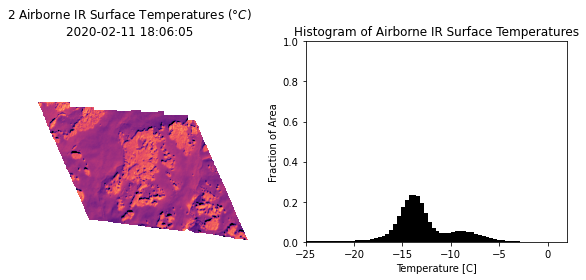

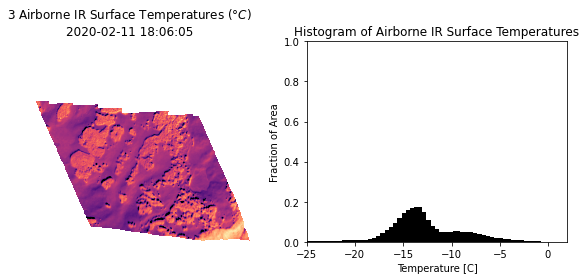

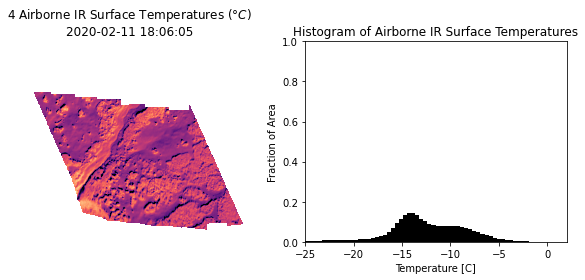

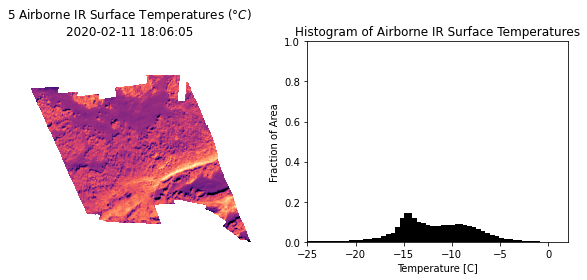

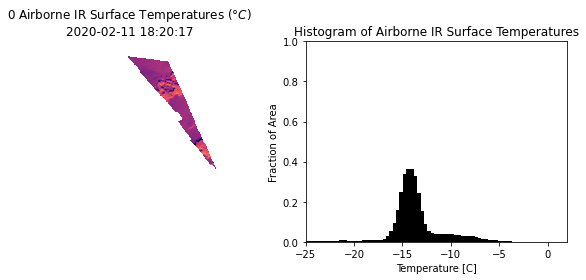

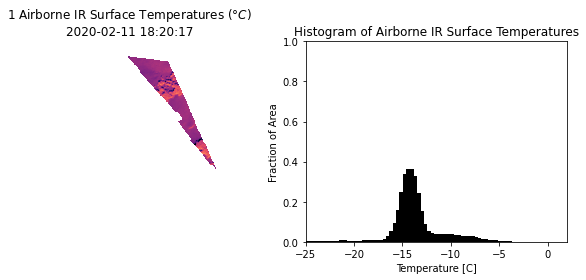

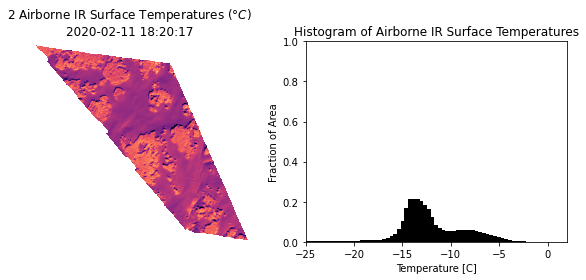

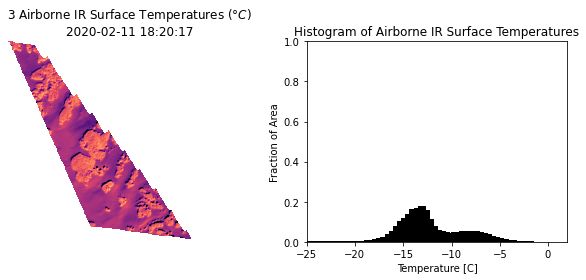

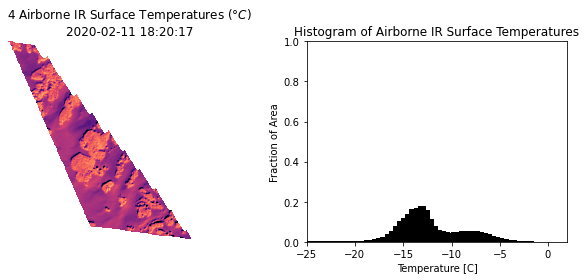

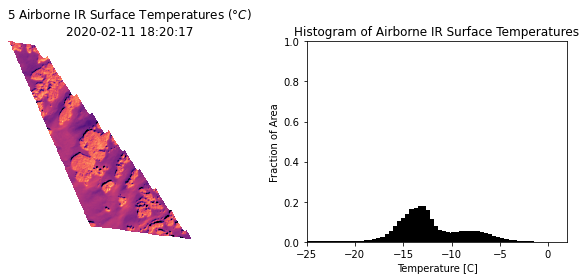

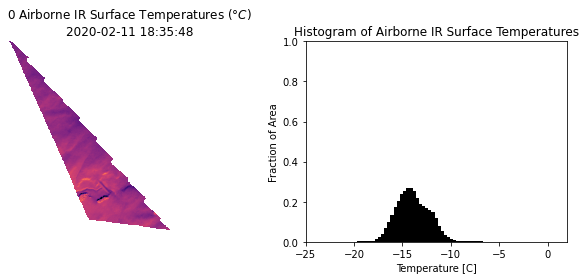

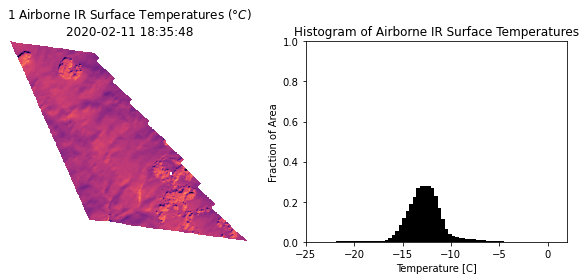

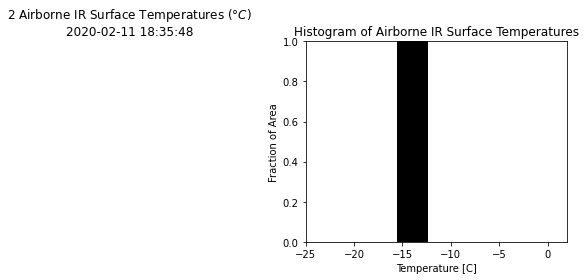

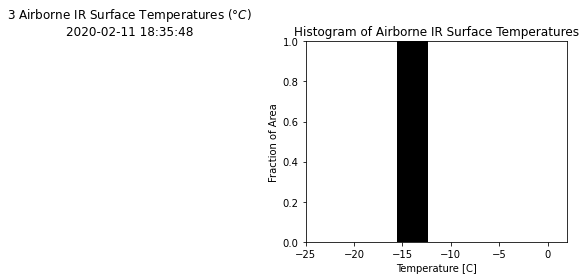

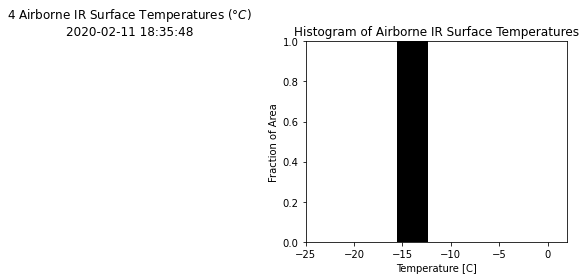

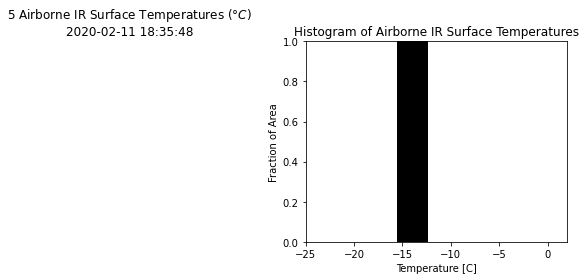

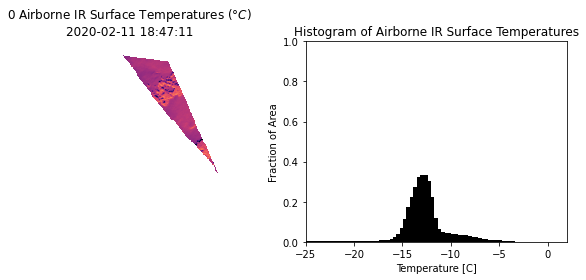

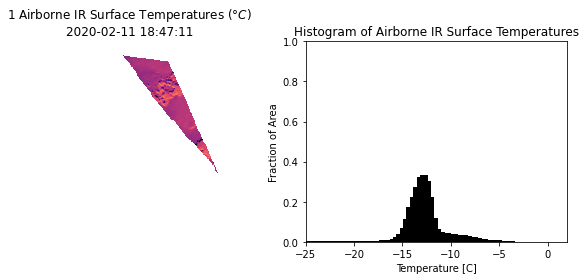

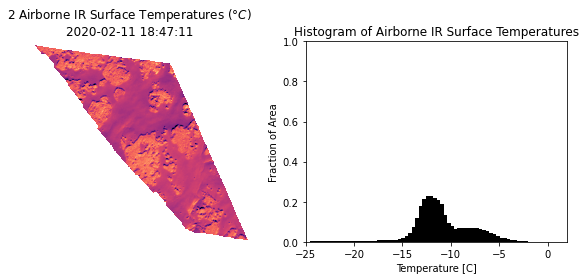

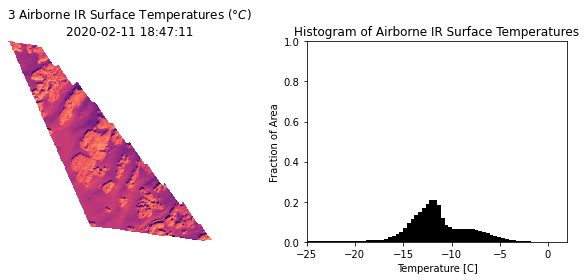

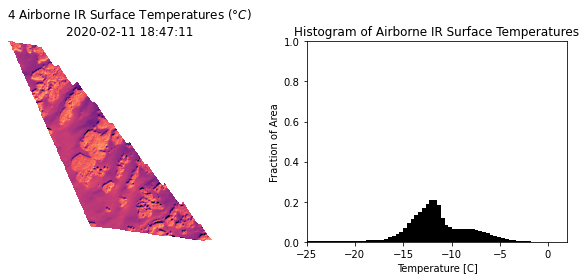

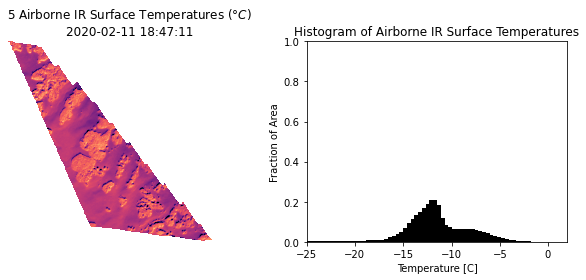

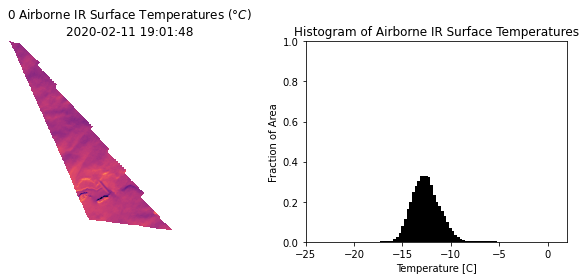

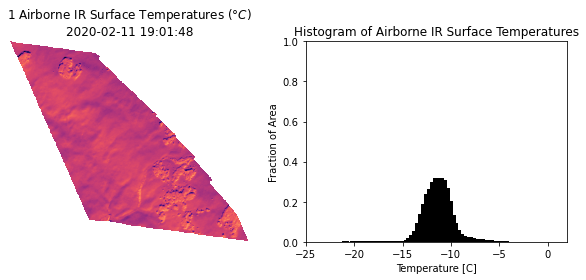

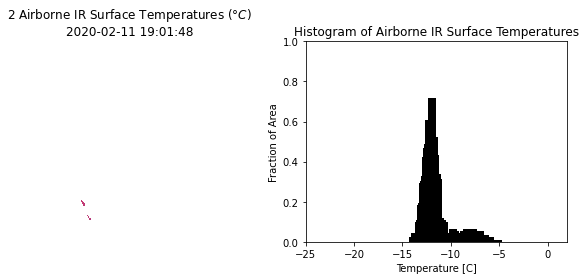

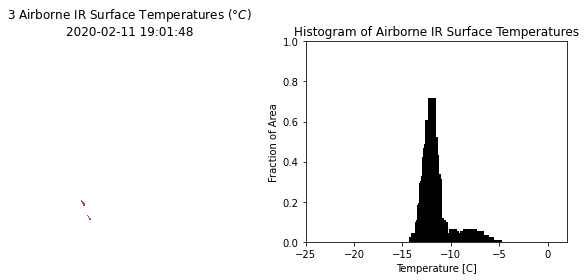

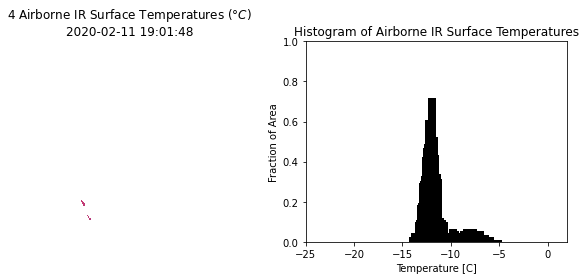

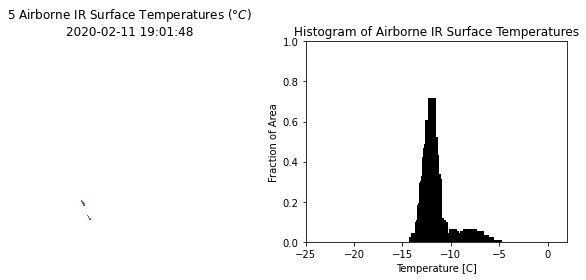

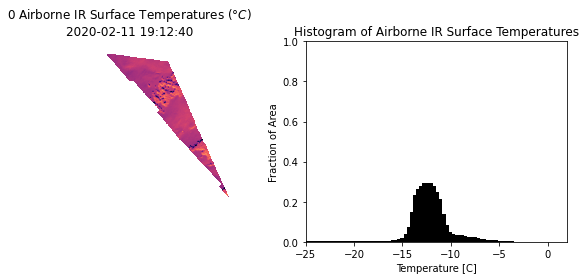

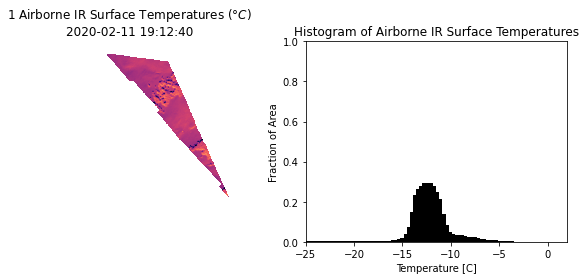

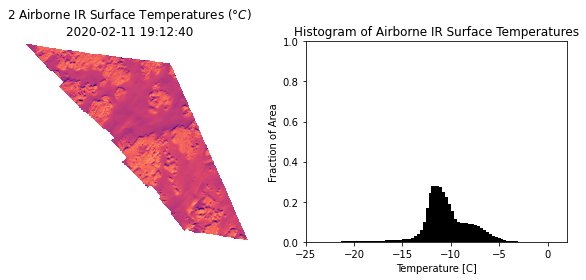

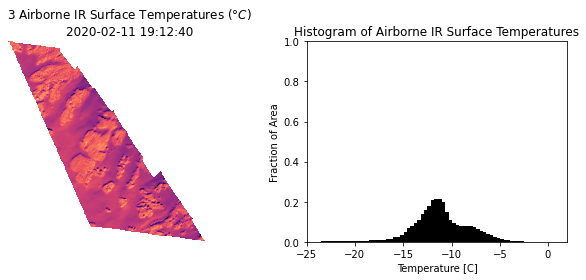

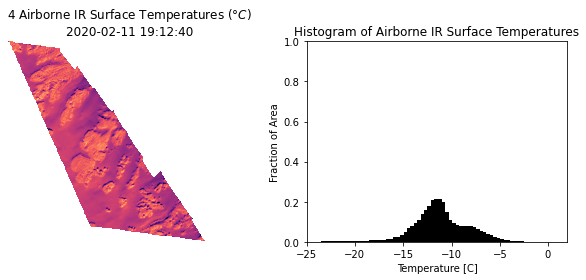

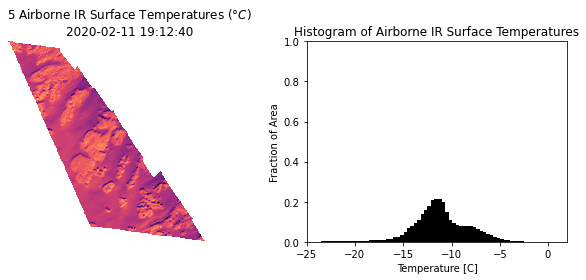

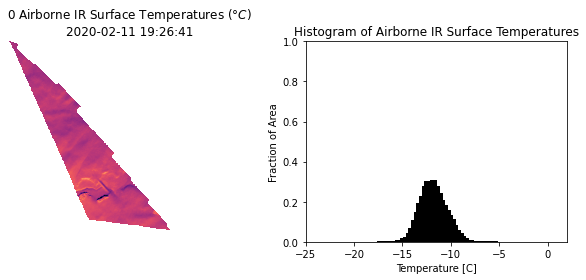

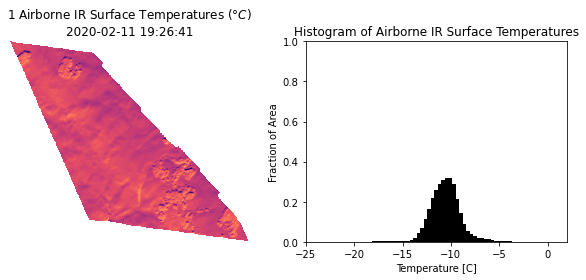

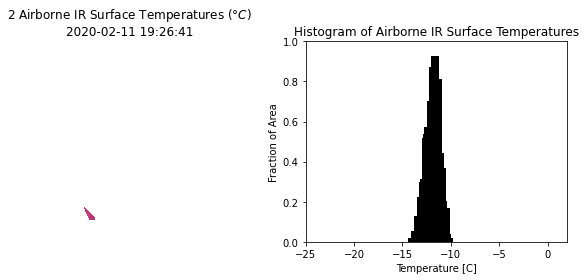

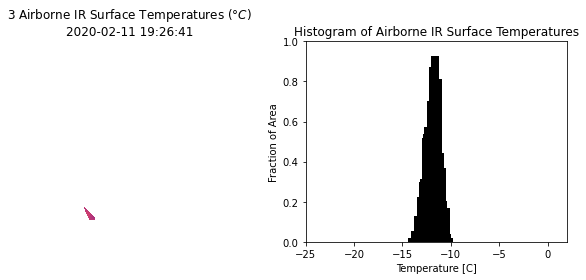

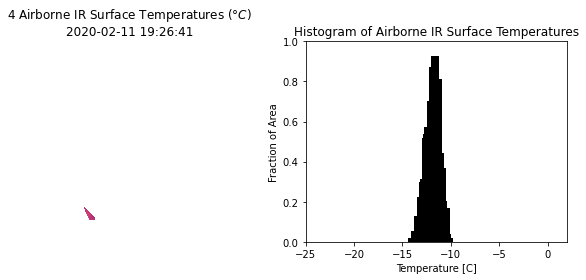

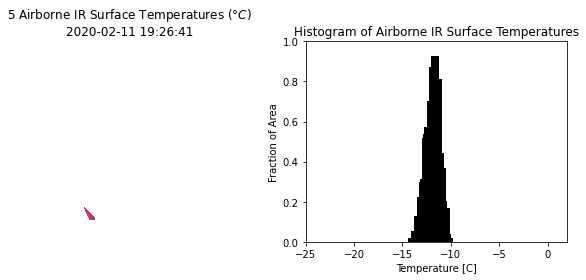

In [24]:
means_list =  []
max_list =  []
min_list =  []
std_list =  []
n_list = []

shapefile_number_list =  []
ir_filepath_list = []
figure_filename_list = []
timestampUTC_list = []

#Tsnow_airborneIR_peak = []
#Ttree_airborneIR_peak = []
#Tsnow_airborneIR_median = []
#Ttree_airborneIR_median = []
#Tsnow_airborneIR_mean = []
#Ttree_airborneIR_mean = []
#Tsnow_airborneIR_min = []
#Ttree_airborneIR_min = []
#Tsnow_airborneIR_max = []
#Ttree_airborneIR_max = []
#Tsnow_airborneIR_std = []
#Ttree_airborneIR_std = []

for ir_filepath in filepaths:
    
    # get timestamp from filename
    datetimelist = ir_filepath.split('\\')[-1].split('_')[-1].split('.')[0].replace("T","-").split("-")
    y = int(datetimelist[0])
    mo = int(datetimelist[1])
    d = int(datetimelist[2])
    h = int(datetimelist[3][:2])
    m = int(datetimelist[3][2:4])
    s = int(datetimelist[3][4:])
    timestampUTC = pd.Timestamp(y, mo, d, h, m, s)
    
    
    for shapefile_number in range(6):
        timestampUTC_list.append(timestampUTC)
        shapefile_number_list.append(shapefile_number)
        ir_filepath_list.append(ir_filepath)
        
        try:
            tb_mean, tb_max, tb_min, tb_std, masked_ir_tb = ir_utils.ir_zonal_stats(ir_filepath, shapefile_filepath, shapefile_number, return_masked_array=True)
        except TypeError:
            None
        
        #print('Brightness Temperature:')
        #print('Mean: {}'.format(np.round(tb_mean,2)))
        #print('Maximum: {}'.format(np.round(tb_max,2)))
        #print('Minimum: {}'.format(np.round(tb_min,2)))
        #print('Standard Deviation: {}'.format(np.round(tb_std,2)))
        
        means_list.append(tb_mean)
        max_list.append(tb_max)
        min_list.append(tb_min)
        std_list.append(tb_std)
        n_list.append(len(masked_ir_tb[~np.isnan(masked_ir_tb)]))
        
        fig, [ax_img, ax_hist] = plt.subplots(nrows=1,ncols=2,figsize=(10,4), tight_layout=True,
                                              gridspec_kw={'width_ratios': [2, 1]})
        
        # Visible image
        #ax_img.imshow(masked_vis[0], origin='lower')
        #ax_img.set_title(f'{shapefile_number} Airborne Visible Image');
        #ax_img.axis('off');
        
        # IR image
        ax_img.imshow(masked_ir_tb[0], cmap='magma', origin='lower', vmin=-25, vmax=0)
        ax_img.set_title(f'{shapefile_number} Airborne IR Surface Temperatures ($\degree C$)\n{timestampUTC}');
        ax_img.axis('off');
        
        # histogram
        data = masked_ir_tb[0]
        x_peaks, y_peaks, x_hist, y_hist = get_hist_peaks(data)
        #x_trough, _, _, _ = get_hist_trough(data)
        #x_hist_snow = x_hist[x_hist < x_trough[0]]
        #y_hist_snow = y_hist[x_hist < x_trough[0]]
        #x_hist_tree = x_hist[x_hist >= x_trough[0]]
        #y_hist_tree = y_hist[x_hist >= x_trough[0]]
        #Tsnow_airborneIR_peak.append(x_peaks[0])
        #Ttree_airborneIR_peak.append(x_peaks[1])
        #Tsnow_airborneIR_median.append(np.median(data[data < x_trough[0]]))
        #Ttree_airborneIR_median.append(np.median(data[data >= x_trough[0]]))
        #Tsnow_airborneIR_mean.append(np.mean(data[data < x_trough[0]]))
        #Ttree_airborneIR_mean.append(np.mean(data[data >= x_trough[0]]))
        #Tsnow_airborneIR_min.append(np.min(data[data < x_trough[0]]))
        #Ttree_airborneIR_min.append(np.min(data[data >= x_trough[0]]))
        #Tsnow_airborneIR_max.append(np.max(data[data < x_trough[0]]))
        #Ttree_airborneIR_max.append(np.max(data[data >= x_trough[0]]))
        #Tsnow_airborneIR_std.append(np.std(data[data < x_trough[0]]))
        #Ttree_airborneIR_std.append(np.std(data[data >= x_trough[0]]))
        
        
        ax_hist.bar(x_hist, y_hist, color='k')
        #ax_hist.bar(x_hist_snow, y_hist_snow, color='lightblue')
        #ax_hist.bar(x_hist_tree, y_hist_tree, color='lightgreen')
        #ax_hist.axvline(np.median(data[data < x_trough[0]]),color='b',linestyle='--')
        #ax_hist.axvline(np.median(data[data >= x_trough[0]]),color='g',linestyle='--')
        #ax_hist.axvline(np.mean(data[data < x_trough[0]]),color='b',linestyle=':')
        #ax_hist.axvline(np.mean(data[data >= x_trough[0]]),color='g',linestyle=':')
        #ax_hist.plot(x_peaks[0], y_peaks[0],'ob')
        #ax_hist.plot(x_peaks[1], y_peaks[1],'^g')
        ax_hist.set_xlim(-25, 2)
        ax_hist.set_ylim(0,1)
        ax_hist.set_ylabel('Fraction of Area')
        ax_hist.set_xlabel('Temperature [C]')
        ax_hist.set_title('Histogram of Airborne IR Surface Temperatures')
        filename_base = ir_filepath.split('\\')[-1].split('.')[0]
        filename = f'g16_{shapefile_number}_{filename_base}'
        figure_filename_list.append(filename)
        plt.savefig(f'{filename}.jpg')
        #plt.close()
        


Save zonal stats results to csv file

In [25]:
df = pd.DataFrame({ 'timestampUTC': timestampUTC_list,
                   'n': n_list,
                   'tb_mean': means_list, 
                   'tb_max': max_list, 
                   'tb_min': min_list, 
                   'tb_std': std_list, 
                   'ir_filepath': ir_filepath_list, 
                   'shapefile_number': shapefile_number_list, 
                   'figure_filename': figure_filename_list})
                    #"Tsnow_airborneIR_peak" : Tsnow_airborneIR_peak  ,
                    #"Ttree_airborneIR_peak" :  Ttree_airborneIR_peak  ,
                    #"Tsnow_airborneIR_median" :  Tsnow_airborneIR_median ,
                    #"Ttree_airborneIR_median" :  Ttree_airborneIR_median ,
                    #"Tsnow_airborneIR_mean" :  Tsnow_airborneIR_mean  ,
                    #"Ttree_airborneIR_mean" :  Ttree_airborneIR_mean  ,
                    #"Tsnow_airborneIR_min" :   Tsnow_airborneIR_min  ,
                    #"Ttree_airborneIR_min" :   Ttree_airborneIR_min  ,
                    #"Tsnow_airborneIR_max" :   Tsnow_airborneIR_max  ,
                    #"Ttree_airborneIR_max" :   Ttree_airborneIR_max  ,
                    #"Tsnow_airborneIR_std" :   Tsnow_airborneIR_std  ,
                    #"Ttree_airborneIR_std" :   Ttree_airborneIR_std  })
df.to_csv(f'g16_{filename_base}.csv')

---